# Word2Vec

Word2vec es una técnica de procesamiento del lenguaje natural que transforma palabras en vectores numéricos, capturando sus significados y relaciones semánticas. Utiliza modelos como CBOW y Skip-gram para analizar el contexto de las palabras en grandes textos, permitiendo que palabras con significados similares tengan vectores cercanos en un espacio multidimensional. Esto facilita tareas como análisis de sentimientos, traducción automática y búsqueda de información, mejorando la comprensión del lenguaje por parte de las máquinas. A continuación analizaremos el modelo.

importemos las librerias necesarias:

In [1]:
%%capture
!pip uninstall numpy -y
!pip install numpy==1.26.4
!pip install gensim==4.3.3
!pip install spacy==3.7.2
!pip install unidecode

Debido a que cambiamos la verison de NumPy es necesario restablecer el entorno

In [1]:
import requests
import numpy as np
import spacy
from unidecode import unidecode
import re
from gensim import models

# 0. Carga de datos

Para este tutorial utilizarás un archivo de texto escrito por Shakespeare. Utiliza el siguente [enlace](https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt) para obtener el conjunto de datos.

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
web = requests.get(url)

texto = web.text
print(texto)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# 1. Recordemos: limpiemos el texto

Formule una rutina de prerpocesamiento que le permita:


1.   Eliminar stopwords
2.   Filtrar palabras por longitud
3.   Normalizar el texto
4.   Quitar grafía
5.   Eliminar caracteres especiales
6.   Eliminar espacios duplicados

Recuerde separar el texto en oraciones antes de procesar el texto, use unicamente la oraciones con almenos 5 palabras.

**Nota:** Por tiempo de procesamiento evalue su funcion con las primeras 1000 oraciones.

In [7]:
# Aumentar el límite de longitud permitida
nlp.max_length = len(texto) + 1000  # un pequeño margen extra

def preprocesar_texto(texto, min_long_palabra=3, max_oraciones=1000):
    doc = nlp(texto)

    # Seleccionamos las oraciones con al menos 5 palabras
    oraciones_validas = [sent.text for sent in doc.sents if len(sent) >= 5][:max_oraciones]

    resultado = []

    for oracion in oraciones_validas:
        # Normalizar (minúsculas)
        oracion = oracion.lower()

        # Quitar grafía
        oracion = unidecode(oracion)

        # Eliminar caracteres especiales
        oracion = re.sub(r'[^a-zA-Z\s]', '', oracion)

        # Eliminar espacios duplicados
        oracion = re.sub(r'\s+', ' ', oracion).strip()

        # Procesar con spaCy para filtrar stopwords y palabras por longitud
        doc_oracion = nlp(oracion)
        tokens_filtrados = [
            token.text for token in doc_oracion
            if not token.is_stop and len(token.text) >= min_long_palabra
        ]

        # Unir tokens limpios
        oracion_limpia = ' '.join(tokens_filtrados)

        if oracion_limpia:
            resultado.append(oracion_limpia)

    return resultado

In [8]:
# Ejecutar la rutina
resultado = preprocesar_texto(texto)

# Mostrar algunas oraciones procesadas
for i, oracion in enumerate(resultado[:10], 1):
    print(f"{i}. {oracion}")

1. citizen proceed hear speak
2. speak speak
3. citizen resolved die famish
4. resolved
5. know caius marcius chief enemy people
6. knowt knowt
7. citizen let kill corn price ist verdict
8. talking ont let away away
9. second citizen word good citizens
10. citizen accounted poor citizens patricians good


In [14]:
##Solución del profesor función:
pat = re.compile(r"[^a-z ]")
spaces = re.compile(r"\s{2,}")
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

def preprocess(text, min_len=1, max_len=23):
    doc = nlp(text)
    # Eliminamos stopwords
    filtered_tokens = [token for token in doc if token.is_stop==False]
    # Filtramos palabras por longitud
    filtered_tokens2 = [token.text for token in filtered_tokens if ((len(token) >= min_len) and (len(token) <= max_len))]
    filtered_text = " ".join(filtered_tokens2)
    # Normalizamos el texto
    norm_text = unidecode(filtered_text)
    # Quitamos grafía
    lower_text = norm_text.lower()
    # Eliminamos caracteres especiales
    clean_text = re.sub(pat, "", lower_text)
    # Eliminamos espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)
    return spaces_text.strip()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
#Corriendo la del profe.
oraciones = texto.split('\n')
oraciones_preprocesadas = [sent.split() for sent in map(preprocess, oraciones) if len(sent.split())>=5]

# 1. Como funciona?


Nota: La idea original de esta clase puede encontrarla en las publicaciones:

*   [Efficient estimation of word representations in Elemento de lista vector space](https://arxiv.org/pdf/1301.3781.pdf)  
*   [Distributed representations of words and phrases and their compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

Estos trabajos proponen dos métodos para aprender representaciones de palabras:

* **Continuous bag-of-words model**: predice la palabra intermedia basándose en las palabras del contexto circundante. El contexto consiste en unas cuantas palabras antes y después de la palabra actual (central). Esta arquitectura se denomina modelo de bolsa de palabras, ya que el orden de las palabras en el contexto no es importante.
* **Continuous skip-gram model**: predice las palabras que se encuentran dentro de un determinado intervalo antes y después de la palabra actual en la misma frase.

Mientras que un modelo de bolsa de palabras predice una palabra a partir del contexto vecino, un modelo de salto de grama predice el contexto (o los vecinos) de una palabra a partir de la propia palabra. El modelo se entrena con n-gramas que permiten omitir fichas (véase un ejemplo en el diagrama siguiente). El contexto de una palabra puede representarse mediante un conjunto de pares de saltogramas `(palabra_objetivo, palabra_contexto)` en los que `palabra_contexto` aparece en el contexto vecino de `palabra_objetivo`.

Considere la siguiente frase de ocho palabras:

> The wide road shimmered in the hot sun.

Las palabras de contexto de cada una de las 8 palabras de esta frase se definen mediante un tamaño de ventana. El tamaño de la ventana determina el intervalo de palabras a cada lado de una `palabra_objetivo` que puede considerarse una `palabra de contexto`. A continuación, se muestra una tabla de «skip-grams» para palabras objetivo basada en distintos tamaños de ventana.

**Nota:** Un tamaño de ventana de `n` implica n palabras en cada lado con un espacio de ventana total de 2*n+1 palabras a través de una palabra.

![word2vec_skipgrams](https://tensorflow.org/text/tutorials/images/word2vec_skipgram.png)

El objetivo de entrenamiento del modelo es maximizar la probabilidad de predecir las palabras del contexto a partir de la palabra objetivo. Para una secuencia de palabras *w<sub>1</sub>, w<sub>2</sub>, ... w<sub>T</sub>*, el objetivo puede expresarse como la probabilidad logarítmica media

![word2vec_skipgram_objective](https://tensorflow.org/text/tutorials/images/word2vec_skipgram_objective.png)

Donde `c` es el tamaño del contexto de entrenamiento. La formulación básica de salto de programa define esta probabilidad mediante la función softmax.

![word2vec_full_softmax](https://tensorflow.org/text/tutorials/images/word2vec_full_softmax.png)

Donde *v* y *v<sup>'<sup>* son representaciones vectoriales de palabras objetivo y de contexto y *W* es el tamaño del vocabulario.

# 1. Gensim

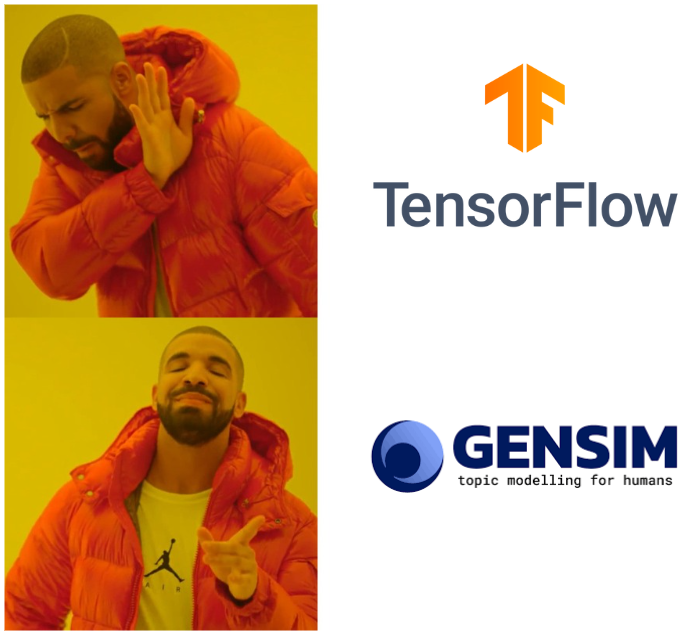

Gensim es una biblioteca de Python de código abierto utilizada para el modelado de temas, indexación de documentos y recuperación de similitud. Permite analizar grandes colecciones de texto y descubrir patrones semánticos ocultos dentro de los documentos. Gensim es popular en el campo del procesamiento del lenguaje natural (PLN) y el aprendizaje automático, ya que ofrece herramientas eficientes para tareas como la creación de modelos de tópicos (por ejemplo, LDA) y la generación de incrustaciones de palabras (word embeddings), como Word2Vec.

## 1.1 Word2Vec en Gensim

La implementación de Word2Vec en Gensim se distingue por su enfoque práctico y eficiente, especialmente en el manejo de grandes volúmenes de texto. Un factor crucial en esta eficiencia es el uso de "negative sampling". Esta técnica aborda el alto costo computacional de entrenar modelos Word2Vec al no intentar actualizar todos los pesos del modelo en cada iteración. En su lugar, para cada palabra objetivo y su contexto, selecciona aleatoriamente un pequeño número de "palabras negativas" (palabras que no aparecen en el contexto) y solo actualiza los pesos asociados con estas palabras y las palabras de contexto reales. Esto reduce drásticamente el número de cálculos necesarios, permitiendo que Gensim entrene modelos Word2Vec de alta calidad en conjuntos de datos extensos de manera mucho más rápida y con menor consumo de recursos. Además, la interfaz intuitiva de Gensim facilita la experimentación y el ajuste de parámetros, permitiendo a los usuarios adaptar el modelo a sus necesidades específicas con relativa facilidad.





En primer lugar, obtengamos nuestro vocabulario.

In [18]:
vocabulary = list(set([token for sent in oraciones_preprocesadas for token in sent]))
print(f'Tamaño del vocabulario: {len(vocabulary)} tokens')

Tamaño del vocabulario: 5606 tokens


La función models.Word2Vec de Gensim ofrece una amplia gama de parámetros que permiten personalizar el entrenamiento del modelo Word2Vec según las necesidades específicas de tu conjunto de datos y tarea. veamolos:

**Parámetros principales:**

* **sentences:**
    * Este parámetro es el corpus de entrenamiento. Debe ser un iterable de listas de tokens (palabras). Por ejemplo, `[['hola', 'mundo'], ['python', 'es', 'genial']]`.
* **vector\_size (size):**
    * Define la dimensionalidad de los vectores de palabras. Valores típicos oscilan entre 100 y 300. Un mayor número de dimensiones puede capturar relaciones más complejas, pero requiere más datos y tiempo de entrenamiento.
* **window:**
    * Especifica el tamaño de la ventana de contexto. Determina cuántas palabras antes y después de la palabra objetivo se consideran para el entrenamiento.
* **min\_count:**
    * Ignora todas las palabras con una frecuencia total inferior a este valor. Esto ayuda a reducir el ruido y el tamaño del vocabulario.
* **workers:**
    * Controla el número de hilos de trabajo para entrenar el modelo. Un mayor número de trabajadores puede acelerar el entrenamiento en sistemas con múltiples núcleos.
* **sg:**
    * Define el algoritmo de entrenamiento. 0 para CBOW (Continuous Bag of Words) y 1 para Skip-gram. Skip-gram tiende a funcionar mejor con conjuntos de datos pequeños y palabras poco frecuentes.
* **hs:**
    * Si es 1, se utiliza softmax jerárquico para el entrenamiento. Si es 0, se utiliza muestreo negativo.
* **negative:**
    * Si se utiliza muestreo negativo (hs=0), este parámetro especifica cuántas "palabras negativas" se deben muestrear.
* **epochs (iter):**
    * Define el número de iteraciones (épocas) sobre el corpus durante el entrenamiento.

**Parámetros adicionales:**

* **alpha:**
    * La tasa de aprendizaje inicial.
* **min\_alpha:**
    * La tasa de aprendizaje mínima.
* **seed:**
    * La semilla para el generador de números aleatorios, para reproducibilidad.

In [19]:
feature_size = 256
window_context = 5
min_word_count = 1
epochs = 7
alpha = 0.025
sg=1

w2v_model = models.word2vec.Word2Vec(
        oraciones_preprocesadas, vector_size=feature_size,
        window=window_context, min_count=min_word_count,
        epochs=epochs, compute_loss=True, alpha=alpha, sg=sg
        )

Ahora extraigamos las representaciones para cada palabra


In [20]:
embeddings = w2v_model.wv[vocabulary]
embeddings.shape

(5606, 256)

Recuerde que la naturaleza matricial del modelo nos permite evaluar la distancia entre dos vectores usando la métrica del coseno.


![word2vec_skipgram_objective](https://media.datacamp.com/cms/google/ad_4nxfkazypnhofcj27wn9i59cw2z-psc16-3dwi-sb_db2e6ec48sgimgtjpiylousnue866zpce9ya4t6iutwi5qdn8ombt4crxxpm4fjhn8qdgmhbd622kcbhouwuhtdvzc2_7zhgzojbryurfxkfg-egyu.png)

Ahora utilicemos esta métrica para identificar las palabras semejantes a otra.

In [22]:
query = w2v_model.wv['father']

norms = np.linalg.norm(embeddings, axis=1)
query_norm = np.linalg.norm(query)
cos_distance = query @ embeddings.T/(norms*query_norm)
order = np.argsort(cos_distance)[::-1]

print(order)

[3115 3713 2127 ...  119 2017 5328]


In [23]:
for i, index in enumerate(order[:100]):
  word = vocabulary[index]
  print(i, word)

0 father
1 hath
2 shall
3 prove
4 house
5 neer
6 friends
7 head
8 set
9 bear
10 till
11 great
12 time
13 comes
14 tears
15 boy
16 forth
17 eye
18 true
19 blood
20 men
21 tis
22 makes
23 home
24 proud
25 poor
26 like
27 doth
28 stand
29 death
30 unto
31 new
32 young
33 world
34 face
35 way
36 nay
37 words
38 o
39 word
40 tongue
41 honour
42 life
43 soul
44 heaven
45 brother
46 noble
47 rest
48 old
49 soon
50 sea
51 thousand
52 child
53 use
54 fair
55 grace
56 foul
57 light
58 looks
59 lord
60 high
61 end
62 wife
63 son
64 die
65 lives
66 man
67 brave
68 find
69 arms
70 daughter
71 best
72 england
73 fear
74 ere
75 queen
76 right
77 power
78 sorrow
79 clarence
80 bloody
81 welcome
82 ah
83 hope
84 means
85 breath
86 saint
87 pale
88 straight
89 friend
90 mean
91 crown
92 look
93 gone
94 lest
95 foot
96 better
97 fire
98 things
99 said


## 1.2 Ejercicio

Usando las representaciones extraídas por el modelo, comprobamos el funcionamiento de "álgebra semántica". Calcule el vector hipotético para la palabra reina (`'queen'`) usando la siguiente ecuación:

$$\hat{queen} = king - man + woman$$

Mida la distancia del coseno entre cada palabra del vocabulario y el vector $\hat{queen}$, ¿si ordenara las distancias en qué posición queda la representación original de la palabra reina?

In [24]:
# Creamos el vector hipotético
query = w2v_model.wv['king'] - w2v_model.wv['man'] + w2v_model.wv['woman']

# Calculamos norma del vector query y de todos los embeddings
norms = np.linalg.norm(embeddings, axis=1)
query_norm = np.linalg.norm(query)

# Distancia del coseno
cos_distance = query @ embeddings.T / (norms * query_norm)

# Ordenamos las palabras por similitud (de mayor a menor)
order = np.argsort(cos_distance)[::-1]

# Imprimimos las primeras 100 palabras más similares
for i, index in enumerate(order[:100]):
    word = vocabulary[index]
    print(i, word)

# Buscamos la posición exacta de 'queen'
queen_index = vocabulary.index('queen')
position = np.where(order == queen_index)[0][0]
print(f"\nLa palabra 'queen' aparece en la posición {position} del ranking.")


0 king
1 edward
2 woman
3 prince
4 son
5 henry
6 fair
7 england
8 richard
9 daughter
10 great
11 looks
12 york
13 unto
14 clarence
15 brother
16 queen
17 proud
18 right
19 sorrow
20 father
21 ground
22 hath
23 duke
24 true
25 comes
26 land
27 farewell
28 lies
29 leave
30 welcome
31 fast
32 doth
33 far
34 deep
35 till
36 bring
37 long
38 lord
39 wife
40 rest
41 home
42 forth
43 sun
44 black
45 george
46 sound
47 tears
48 lives
49 gave
50 young
51 die
52 mistress
53 ha
54 boy
55 valiant
56 sea
57 high
58 friends
59 earl
60 gods
61 live
62 beauty
63 place
64 end
65 hereford
66 twas
67 soon
68 poor
69 gracious
70 look
71 norfolk
72 house
73 blood
74 crown
75 mad
76 save
77 living
78 stanley
79 send
80 god
81 air
82 grave
83 find
84 hell
85 bed
86 death
87 hold
88 makes
89 kind
90 uncle
91 earth
92 light
93 gentle
94 gone
95 arms
96 words
97 oxford
98 heaven
99 arm

La palabra 'queen' aparece en la posición 16 del ranking.
